## 0. Introduction
Objectif : explorer et nettoyer le dataset des pénalités de rugby pour préparer la phase de modélisation (classification binaire).

## 1. Import & configuration

In [33]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import seaborn as sns
from dotenv import load_dotenv


pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")
load_dotenv()

sys.path.insert(0, "..")
from config import RAW_DATA_PATH, FIG_DIR, INTERIM_DATA_PATH, REPORT_DIR, TARGET_COL
from utils import detect_outliers_zscore
print(f"✅ Config loaded: RAW_DATA_PATH={RAW_DATA_PATH}, FIG_DIR={FIG_DIR}, INTERIM_DATA_PATH={INTERIM_DATA_PATH}, REPORT_DIR={REPORT_DIR}")

✅ Config loaded: RAW_DATA_PATH=/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/data/raw/final_kicks_dataset.csv, FIG_DIR=/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/outputs/figures, INTERIM_DATA_PATH=/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/data/interim/kicks_clean.csv, REPORT_DIR=/Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/outputs/reports


## 2. Chargement du dataset

In [34]:
df = pd.read_csv(RAW_DATA_PATH, sep=";")  
print(f"✅ Dataset chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")

df.head()

✅ Dataset chargé : 17342 lignes, 19 colonnes


,x,y,is_left_footed,game_away,start,minute,half,is_endgame,is_start,time_norm,distance,angle,is_left_side,n_attempts_before,success_rate_before,has_previous_attempts,wind_speed,precipitation_probability,resultat
0,12,66,0,0,493,8,1,0,0,"0,1",41,34,1,0,"0,5",0,"1,3","0,02",1
1,70,72,0,0,1481,25,1,0,0,"0,31",45,51,0,1,100,1,"1,3","0,02",1
2,23,62,0,0,2011,34,1,0,0,"0,42",40,18,1,2,100,1,"1,3","0,02",1
3,51,85,0,0,2285,38,1,0,0,"0,48",22,47,0,3,100,1,"1,3","0,02",1
4,51,73,0,0,4495,75,2,0,0,"0,94",31,31,0,4,100,1,"1,3","0,02",0


## 3. Informations globales

In [35]:
df.info()
display(df.describe(include="all").T.head(15))
df.isna().sum().sort_values(ascending=False).head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17342 entries, 0 to 17341
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   x                          17342 non-null  int64 
 1   y                          17342 non-null  int64 
 2   is_left_footed             17342 non-null  int64 
 3   game_away                  17342 non-null  int64 
 4   start                      17342 non-null  int64 
 5   minute                     17342 non-null  int64 
 6   half                       17342 non-null  int64 
 7   is_endgame                 17342 non-null  int64 
 8   is_start                   17342 non-null  int64 
 9   time_norm                  17342 non-null  object
 10  distance                   17342 non-null  int64 
 11  angle                      17342 non-null  int64 
 12  is_left_side               17342 non-null  int64 
 13  n_attempts_before          17342 non-null  int64 
 14  succes

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
x,17342.0,NaN,NaN,NaN,34.652232,19.85146,1.0,18.0,35.0,51.0,70.0
y,17342.0,NaN,NaN,NaN,76.382539,9.882594,40.0,73.0,76.0,84.0,98.0
is_left_footed,17342.0,NaN,NaN,NaN,0.153097,0.360091,0.0,0.0,0.0,0.0,1.0
game_away,17342.0,NaN,NaN,NaN,0.428901,0.494933,0.0,0.0,0.0,1.0,1.0
start,17342.0,NaN,NaN,NaN,3393.377292,2070.699701,50.0,1498.25,2963.0,5274.0,9335.0
minute,17342.0,NaN,NaN,NaN,56.568043,34.512385,1.0,25.0,49.0,88.0,156.0
half,17342.0,NaN,NaN,NaN,1.587648,0.492272,1.0,1.0,2.0,2.0,2.0
is_endgame,17342.0,NaN,NaN,NaN,0.377407,0.484752,0.0,0.0,0.0,1.0,1.0
is_start,17342.0,NaN,NaN,NaN,0.019029,0.136631,0.0,0.0,0.0,0.0,1.0
time_norm,17342,100,1,5770,NaN,NaN,NaN,NaN,NaN,NaN,NaN


x                            0
distance                     0
precipitation_probability    0
wind_speed                   0
has_previous_attempts        0
success_rate_before          0
n_attempts_before            0
is_left_side                 0
angle                        0
time_norm                    0
dtype: int64

## 4. Nettoyage de base

In [36]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df = df.drop_duplicates()


if TARGET_COL in df.columns:
    df = df.dropna(subset=[TARGET_COL])

object_cols = df.select_dtypes(include="object").columns
for col in object_cols:
	df[col] = df[col].str.replace(",", ".").astype(float)

## 5. Analyse univariée

### 5.1 Variables numériques

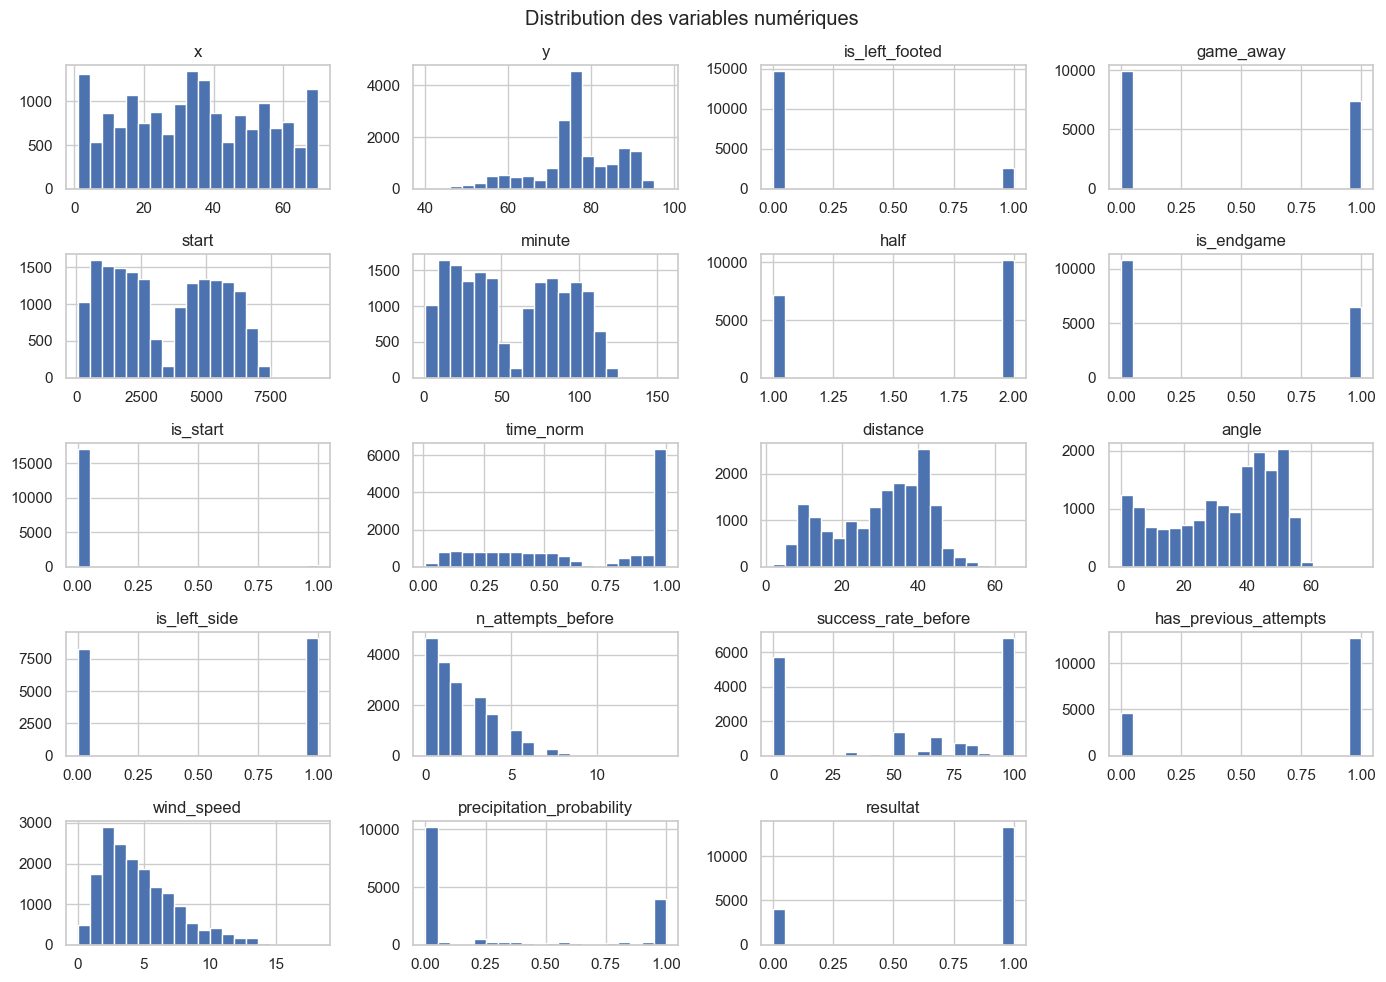

In [37]:
num_cols = df.select_dtypes(include=np.number).columns
df[num_cols].hist(bins=20, figsize=(14, 10))
plt.suptitle("Distribution des variables numériques")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/numeric_distributions.png")
plt.show()

### 5.2 Variables catégorielles

In [38]:
cat_cols = df.select_dtypes(exclude=np.number).columns
if len(cat_cols) == 0:
	print("🙅🏻 Aucune variable catégorielle à analyser.")
else:
	for col in cat_cols:
		plt.figure(figsize=(8, 4))
		sns.countplot(data=df, x=col, hue=TARGET_COL)
		plt.title(f"Répartition par {col}")
		plt.xticks(rotation=45)
		plt.tight_layout()
		plt.savefig(f"{FIG_DIR}/{col}_distribution.png")
		plt.show()

🙅🏻 Aucune variable catégorielle à analyser.


### 5.3 Distribution des variables vs la variable cible

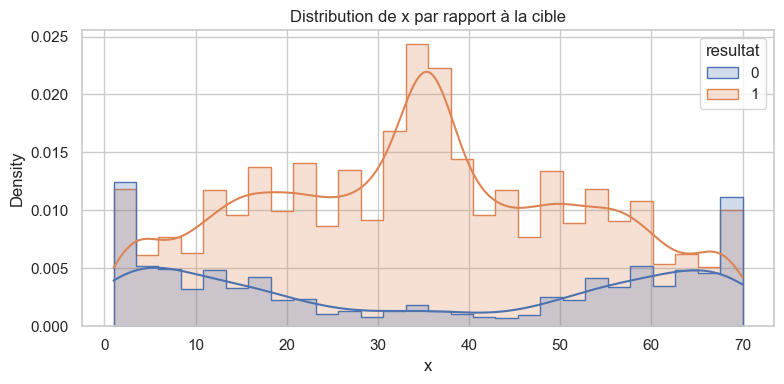

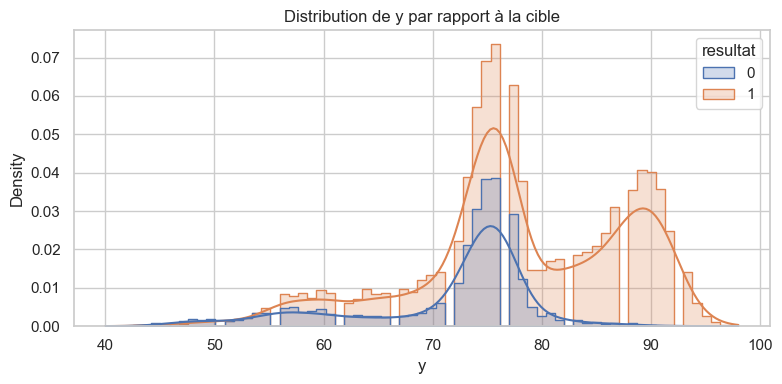

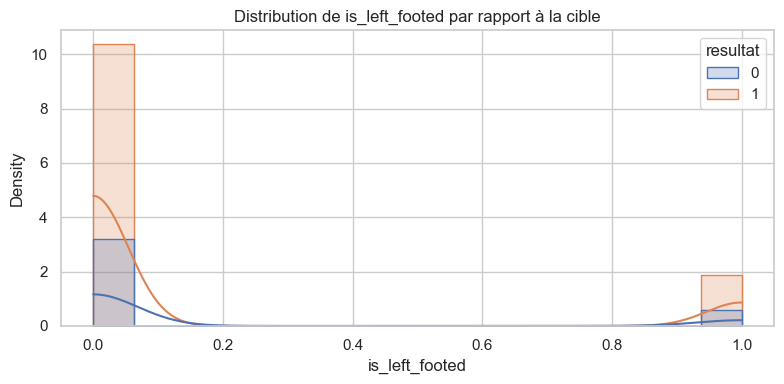

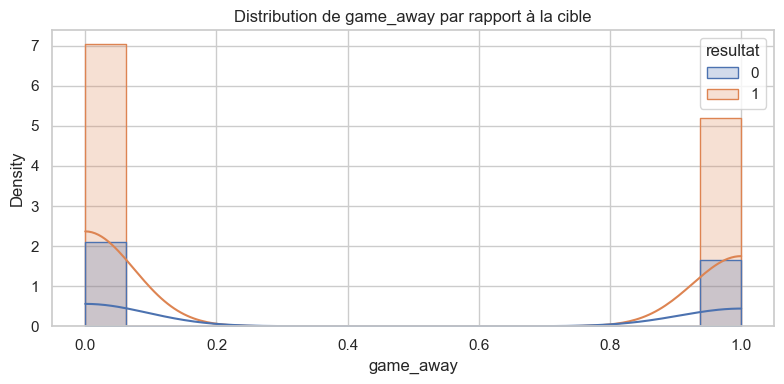

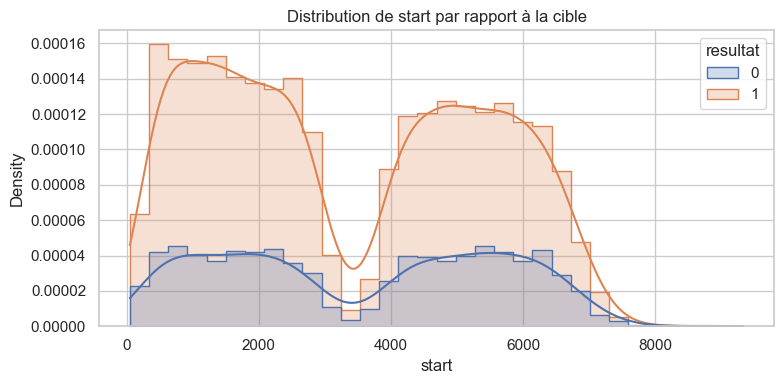

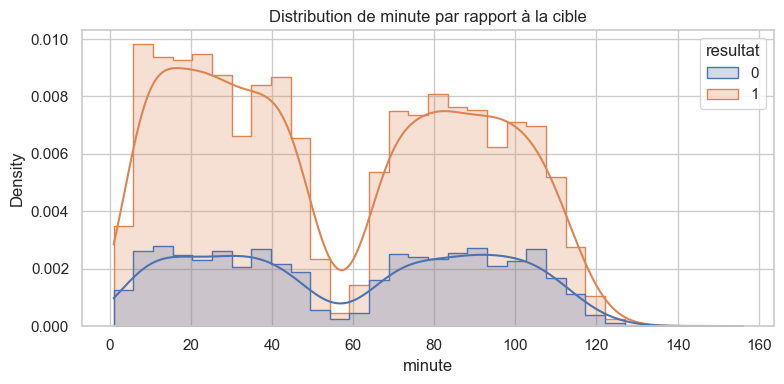

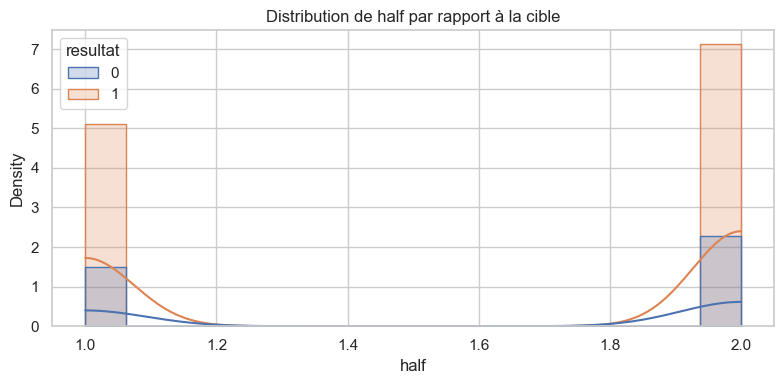

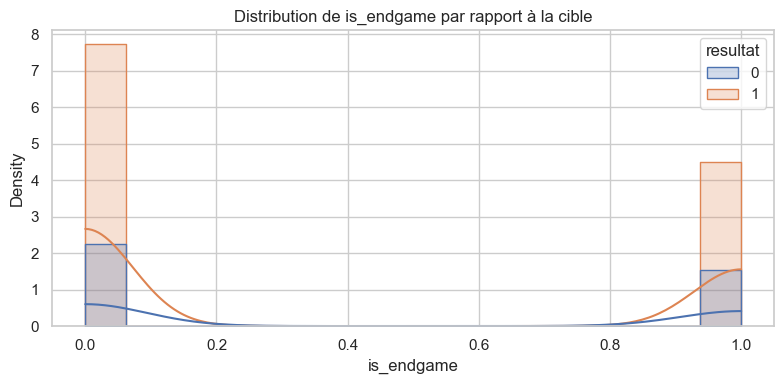

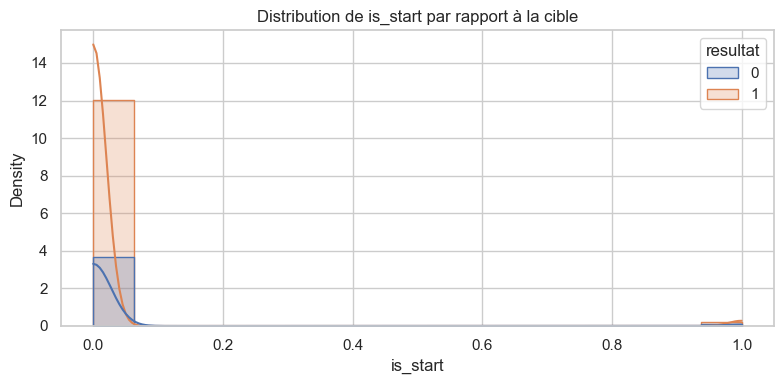

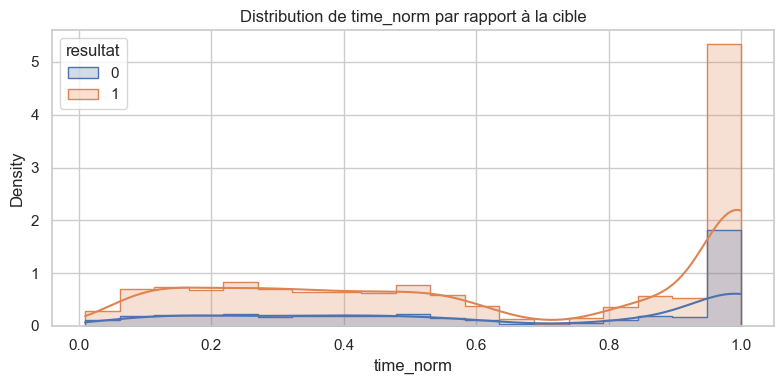

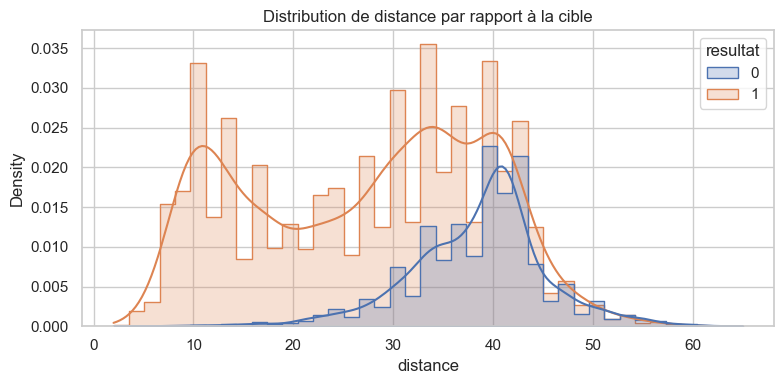

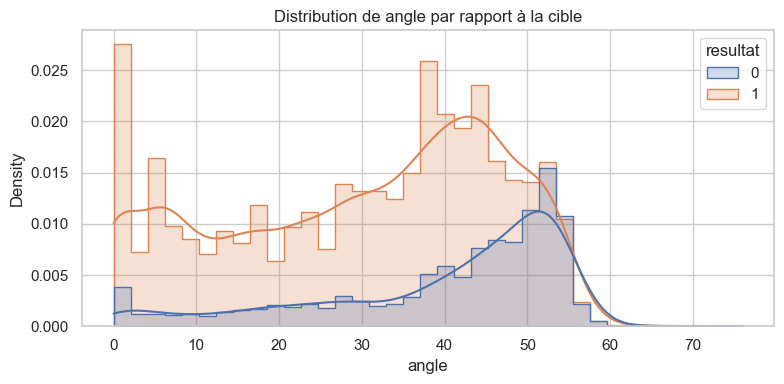

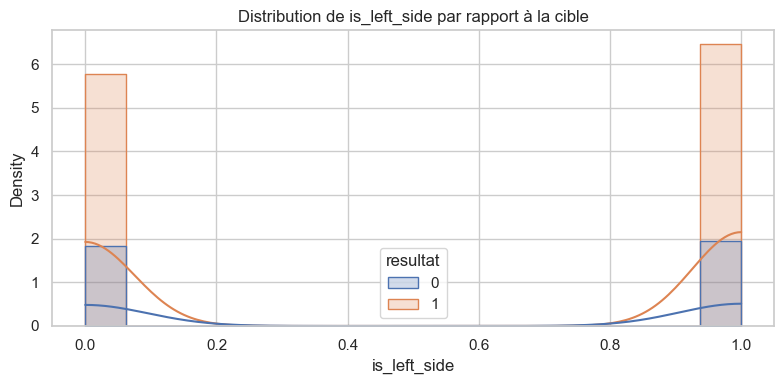

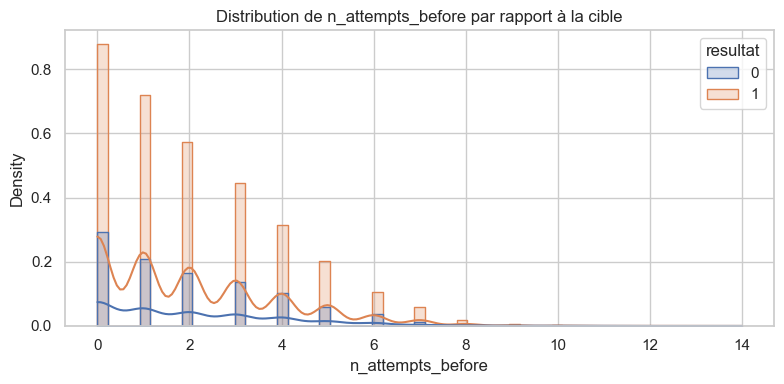

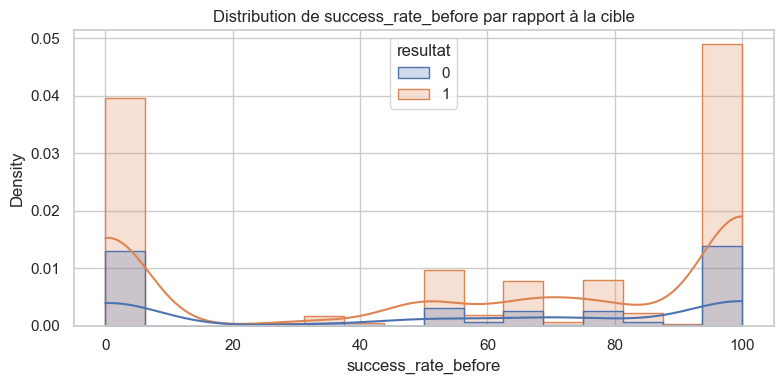

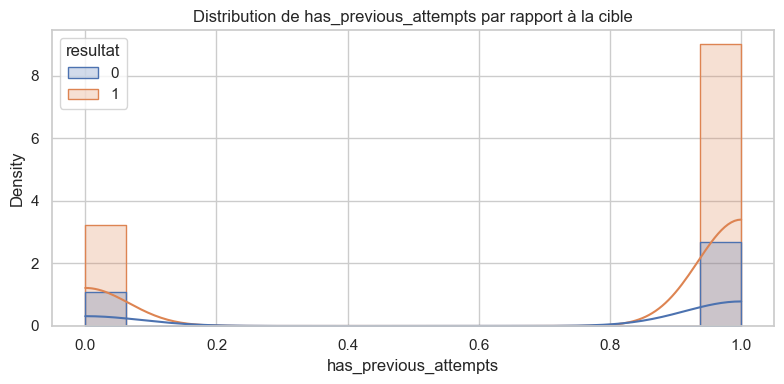

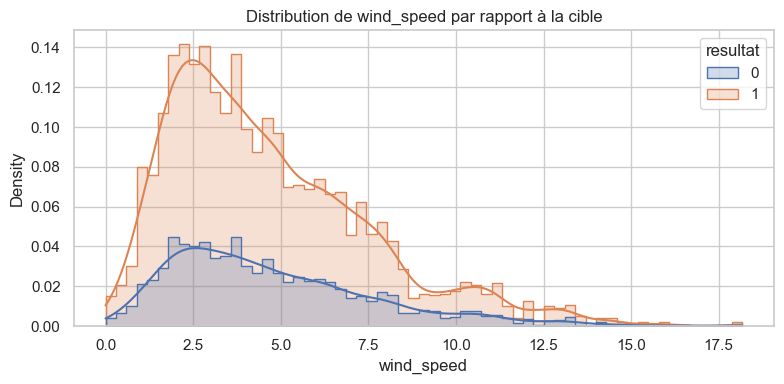

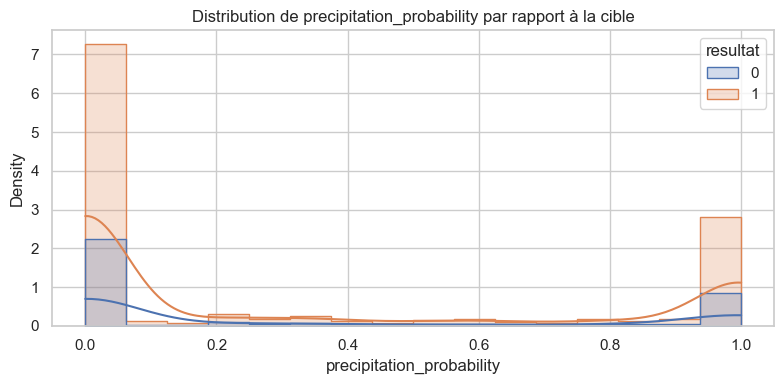

In [39]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
if TARGET_COL in num_cols:
	num_cols.remove(TARGET_COL)

for col in num_cols:
	plt.figure(figsize=(8, 4))
	sns.histplot(data=df, x=col, hue=TARGET_COL, kde=True, element="step", stat="density")
	plt.title(f"Distribution de {col} par rapport à la cible")
	plt.tight_layout()
	plt.savefig(f"{FIG_DIR}/distribution_{col}_by_target.png")
	plt.show()

### 5.4 Identification des outliers dans les variables numériques

In [40]:
# Z-score et détection des outliers
print("Using Z-score method:")

outlier_rows, outlier_details, summary = detect_outliers_zscore(
    df, threshold=3.0
)

print(f"Nombre de lignes avec au moins un outlier : {len(outlier_rows)}\n")

print("Résumé des outliers par colonne :")
for col, stats in summary.items():
    if stats["count"] > 0:
        print(f"{col}: {stats['count']} outliers ({stats['percent']:.2f}%)")

csv_path = f"{REPORT_DIR}/outlier_rows_zscore.csv"
outlier_rows.to_csv(csv_path, index=False)
print(f"\n✅ Les lignes avec outliers ont été sauvegardées dans : {csv_path}")


Using Z-score method:
Nombre de lignes avec au moins un outlier : 702

Résumé des outliers par colonne :
y: 56 outliers (0.32%)
is_start: 330 outliers (1.90%)
n_attempts_before: 174 outliers (1.00%)
wind_speed: 146 outliers (0.84%)

✅ Les lignes avec outliers ont été sauvegardées dans : /Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/outputs/reports/outlier_rows_zscore.csv


## 6. Corrélations

### 6.1 Matrice de Pearson

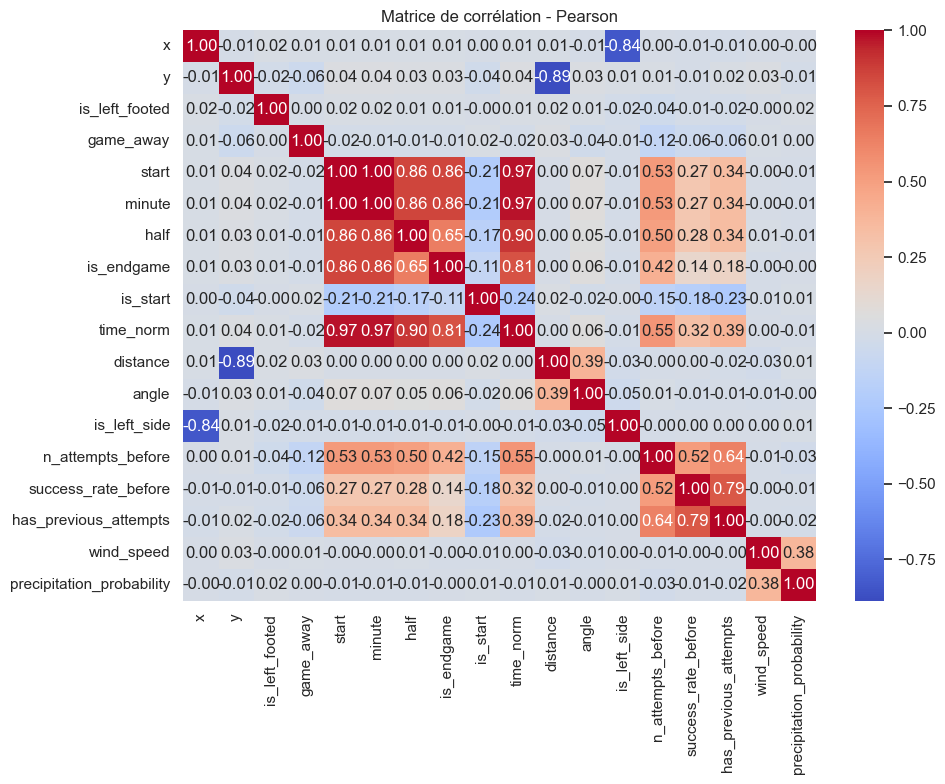

In [41]:
corr_pearson = df[num_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_pearson, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation - Pearson")
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/correlation_matrix_pearson.png")
plt.show()

## 6.2 Comparatif Pearson vs Spearman

In [42]:
corr_pearson = df.corr(method="pearson")[TARGET_COL].sort_values(ascending=False)
corr_spearman = df.corr(method="spearman")[TARGET_COL].sort_values(ascending=False)

corr_compare = pd.concat(
    [corr_pearson.rename("pearson"), corr_spearman.rename("spearman")], axis=1
)
corr_compare.style.background_gradient(cmap="coolwarm", axis=None)

,pearson,spearman
resultat,1.000000,1.000000
y,0.280476,0.282668
success_rate_before,0.027404,0.027572
has_previous_attempts,0.021365,0.021365
is_left_side,0.011697,0.011697
n_attempts_before,0.007817,0.011091
precipitation_probability,0.001756,0.002331
is_left_footed,-0.001127,-0.001127
x,-0.007384,-0.000225
wind_speed,-0.010077,-0.010051


## 6.3 Clean des corrélations et léger feature engineering

### Migré vers 02_features.ipynb

## 7. Répartition de la cible

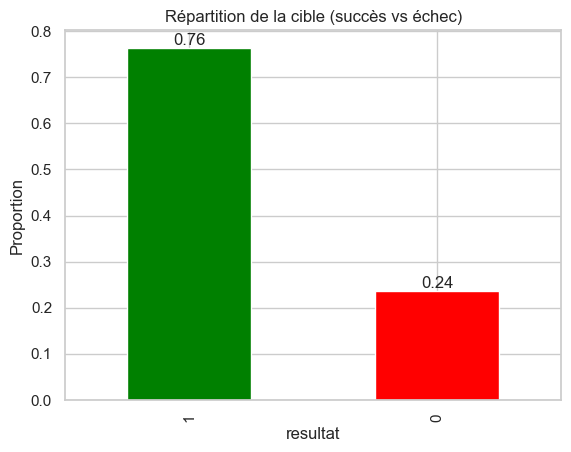

resultat
1    0.764214
0    0.235786
Name: proportion, dtype: float64


In [43]:
if TARGET_COL in df.columns:
	target_counts = df[TARGET_COL].value_counts(normalize=True)
	ax = target_counts.plot(kind="bar", color=["green", "red"])
	plt.title("Répartition de la cible (succès vs échec)")
	plt.ylabel("Proportion")
	ax.bar_label(ax.containers[0], fmt="%.2f") # type: ignore
	plt.savefig(f"{FIG_DIR}/target_distribution.png")
	plt.show()
	print(target_counts)

## 8. Rapport automatique

In [44]:
profile = ProfileReport(df, title="Rugby Kicks EDA Report", explorative=True)
profile.to_file(f"{REPORT_DIR}/eda_profile.html")
print("[bold cyan]📄 Rapport EDA généré : outputs/reports/eda_profile.html[/bold cyan]")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 231.17it/s]

[bold cyan]📄 Rapport EDA généré : outputs/reports/eda_profile.html[/bold cyan]


## 9. Sauvegarde du dataset nettoyé pour l'étape de feature engineering

In [45]:
# Aperçu
print(f"Dataset final : {df.shape[0]} lignes × {df.shape[1]} colonnes")

# Sauvegarde principale
df.to_csv(INTERIM_DATA_PATH, index=False)

print(f"[bold green]💾 Données nettoyées enregistrées dans {INTERIM_DATA_PATH}[/bold green]")

Dataset final : 17342 lignes × 19 colonnes
[bold green]💾 Données nettoyées enregistrées dans /Users/xaviercoulon/Documents/OC/OC_P6_Rugby_MLOps/data/interim/kicks_clean.csv[/bold green]
